<a href="https://www.kaggle.com/code/neuralsrg/e2s-transformer?scriptVersionId=139205430" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# EEG to Speech Transformer

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! rm -rf /kaggle/working/PyTorchWavelets
! git clone https://github.com/neuralsrg/PyTorchWavelets.git
# ! git clone -b develop --single-branch https://github.com/neuralsrg/PyTorchWavelets.git

Cloning into 'PyTorchWavelets'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 108 (delta 1), reused 5 (delta 1), pack-reused 100
Receiving objects: 100% (108/108), 1.08 MiB | 6.65 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [3]:
import os
import sys
import random
sys.path.append('/kaggle/working/PyTorchWavelets/')
import subprocess

import math
import pickle
from glob import glob
from functools import partial
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Optional
from IPython.display import Audio, FileLink, display, clear_output

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio
import torch.nn as nn
torch.manual_seed(1337)
from torch.utils.data import Dataset, DataLoader

from wavelets_pytorch.transform import WaveletTransformTorch
from wavelets_pytorch.wavelets import Morlet

from sklearn.decomposition import PCA
# clear_output()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Configuration

In [4]:
base = '/kaggle/input/internal-speech-recognition/Vartanov/audios'

A = "A.wav"
B = "B.wav"
F = "F.wav"
G = "G.wav"
M = "M.wav"
R = "R.wav"
U = "U.wav"

Ba = "Ba.wav"
Bu = "Bu.wav"
Fa = "Fa.wav"
Fu = "Fu.wav"
Ga = "Ga.wav"
Gu = "Gu.wav"
Ma = "Ma.wav"
Mu = "Mu.wav"
Ra = "Ra.wav"
Ru = "Ru.wav"

Biblioteka = "St1.wav"
Raketa = "St2.wav"
Kurier = "St3.wav"
Ograda = "St4.wav"
Haketa = "St5.wav"

phonemes_m3_labels = {
    12: os.path.join(base, "phonemes", A),
    22: os.path.join(base, "phonemes", A),
    13: os.path.join(base, "phonemes", B),
    23: os.path.join(base, "phonemes", B),
    14: os.path.join(base, "phonemes", F),
    24: os.path.join(base, "phonemes", F),
    15: os.path.join(base, "phonemes", G),
    25: os.path.join(base, "phonemes", G),
    16: os.path.join(base, "phonemes", M),
    26: os.path.join(base, "phonemes", M),
    17: os.path.join(base, "phonemes", R),
    27: os.path.join(base, "phonemes", R),
    18: os.path.join(base, "phonemes", U),
    28: os.path.join(base, "phonemes", U)
}

phonemes_m4_labels = {
    1: os.path.join(base, "phonemes", A),
    11: os.path.join(base, "phonemes", A),
    2: os.path.join(base, "phonemes", B),
    12: os.path.join(base, "phonemes", B),
    3: os.path.join(base, "phonemes", F),
    13: os.path.join(base, "phonemes", F),
    4: os.path.join(base, "phonemes", G),
    14: os.path.join(base, "phonemes", G),
    5: os.path.join(base, "phonemes", M),
    15: os.path.join(base, "phonemes", M),
    6: os.path.join(base, "phonemes", R),
    16: os.path.join(base, "phonemes", R),
    7: os.path.join(base, "phonemes", U),
    17: os.path.join(base, "phonemes", U)
}

syllables_labels = {
    1: os.path.join(base, "syllables", Ba),
    11: os.path.join(base, "syllables", Ba),
    2: os.path.join(base, "syllables", Fa),
    12: os.path.join(base, "syllables", Fa),
    3: os.path.join(base, "syllables", Ga),
    13: os.path.join(base, "syllables", Ga),
    4: os.path.join(base, "syllables", Ma),
    14: os.path.join(base, "syllables", Ma),
    5: os.path.join(base, "syllables", Ra),
    15: os.path.join(base, "syllables", Ra),
    6: os.path.join(base, "syllables", Bu),
    16: os.path.join(base, "syllables", Bu),
    7: os.path.join(base, "syllables", Ru),
    17: os.path.join(base, "syllables", Ru),
    8: os.path.join(base, "syllables", Mu),
    18: os.path.join(base, "syllables", Mu),
    9: os.path.join(base, "syllables", Fu),
    19: os.path.join(base, "syllables", Fu),
    10: os.path.join(base, "syllables", Gu),
    20: os.path.join(base, "syllables", Gu)
}

words_labels = {
    11: os.path.join(base, "words", Biblioteka),
    21: os.path.join(base, "words", Biblioteka),
    12: os.path.join(base, "words", Raketa),
    22: os.path.join(base, "words", Raketa),
    13: os.path.join(base, "words", Kurier),
    23: os.path.join(base, "words", Kurier),
    14: os.path.join(base, "words", Ograda),
    24: os.path.join(base, "words", Ograda),
    15: os.path.join(base, "words", Haketa),
    25: os.path.join(base, "words", Haketa)
}

sections = ["syllables", "phonemes_m3", "phonemes_m4", "words"]

audio_map = {
    "syllables": syllables_labels,
    "phonemes_m3": phonemes_m3_labels,
    "phonemes_m4": phonemes_m4_labels,
    "words": words_labels
}

config = {
    
    'path': '/kaggle/input/internal-speech-recognition/Vartanov/feather',
    'audio_maps': audio_map,
    
    # EEG
    'eeg_sr': 1006,
    'n_channels': 63,
    'in_seq_len': 1145,
    
    # Wavelet Transform
    'dj': 0.8,  # wavelet scaling factor
    'wavelet': Morlet,
    'n_wvt_bins': 12,
    
    # Audio
    'audio_sr': 44100,
    'sound_size': 50176,
    
    # STFT Patameters
    'n_fft': 2048,
    'hop_size': 512,
    
    # Model
    
    # Convolution Module
    'kernel_size': 31,
    'conv_module_dropout': .1,
    
    # Positional Encoding
    'emb_dropout': .1,
    
    # Transformer
    'd_model': 512,
    'nhead': 8,
    'num_encoder_layers': 6,
    'num_decoder_layers': 6,
    'dim_feedforward': 2048,
    'dropout': 0.1,
    'activation': 'relu',
    
    # Scheduler
    'base_lr': 0.2,
    'min_lr': 1e-5,
}

audio_paths = glob('/kaggle/input/internal-speech-recognition/Vartanov/audios/syllables/*.wav') + \
              glob('/kaggle/input/internal-speech-recognition/Vartanov/audios/words/*.wav')

In [5]:
# spectrogram to sound

def restore(D: np.array, frame_size=config['n_fft'], hop_length=config['hop_size'], epochs: int = 2, window: str = 'hann'):

    length = (D.shape[1] + 1) * hop_length  # (D.shape[1] - 1 + 2) * hop_length
    D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
    mag, _ = librosa.magphase(D)
    phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
    x_ = librosa.istft(mag * phase, hop_length=hop_length, center=True, window=window, length=length)

    for i in range(epochs):
        _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=True,
                                                 window=window))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=True, window=window, length=length)

    return x_[hop_length:-hop_length]

# Dataset

In [6]:
class EEGDataset(Dataset):
    def __init__(self, path: str, audio_maps: dict, fragment_length: int = 2012, partition_size: int = 32,
                 sample_rate: int = 44100, sound_channel: int = 1, val_ratio: float = 0.15, seed: int = 1337):
        '''
        path: path to sections (folders)
        audio_maps: two-level map: section names -> labels -> audio_paths
        fragment_lengtht: length of fragment after label
        partition_size: number of nonzero labels in each csv file
        '''
        super().__init__()
        rnd = random.Random(seed)
        
        self.sections = os.listdir(path)
        rnd.shuffle(self.sections)
        assert set(self.sections) == set(audio_maps.keys()), "Sections must be the same!"
        self.audio_maps = audio_maps
        
        all_paths = []
        for sec in self.sections:
            l = os.listdir(os.path.join(path, sec))
            rnd.shuffle(l)
            all_paths.append([os.path.join(path, sec, file) for file in l])
                
        # all_paths = [[os.path.join(path, sec, file) for file in sorted(os.listdir(os.path.join(path, sec)))] for sec in self.sections]
        num_all_files = [len(elem) for elem in all_paths]
        splits = [int(elem * val_ratio) for elem in num_all_files]
        
        self.val_paths = [sec_paths[:split] for sec_paths, split in zip(all_paths, splits)]
        self.paths = [sec_paths[split:] for sec_paths, split in zip(all_paths, splits)]
        
        self.sec_num_files = [len(elem) for elem in self.paths]
        self.sec_cumnum = np.cumsum(self.sec_num_files) * partition_size
        self.total_num_files = sum(self.sec_num_files)
        
        self.sec_num_val_files = [len(elem) for elem in self.val_paths]
        self.sec_val_cumnum = np.cumsum(self.sec_num_val_files) * partition_size
        self.total_num_val_files = sum(self.sec_num_val_files)
        
        self.partition_size = partition_size
        self.fragment_length = fragment_length
        self.sr = sample_rate
        self.sound_channel = sound_channel
        self.val_mode = False
        
    def __len__(self) -> int:
        num = self.total_num_val_files if self.val_mode else self.total_num_files
        return num * self.partition_size
    
    def set_val_mode(self, mode: bool):
        '''
        Switch between train/val subsets
        '''
        assert mode in [True, False], "Incorrect mode type!"
        self.val_mode = mode
        return self
    
    def to_section(self, idx: int) -> Tuple[int, int]:
        '''
        Get file section and inner index by its absolute index
        '''
        cumnum = self.sec_val_cumnum if self.val_mode else self.sec_cumnum
        section = np.where(idx < cumnum)[0][0]
        section_idx = idx if (section == 0) else (idx - cumnum[section - 1])
        return section, section_idx
    
    def get_audio(self, section: str, label: int) -> torch.Tensor:
        '''
        Get audio by section and corresponding label
        '''
        section_name = self.sections[section]
        audio, current_sr = torchaudio.load(self.audio_maps[section_name][label])
        audio = torchaudio.functional.resample(audio, orig_freq=current_sr, new_freq=self.sr)
        return audio[self.sound_channel]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        '''
        int idx: file ID
        return: EEG fragment with its corresponding audio
        '''
        section, section_idx = self.to_section(idx)
        paths_source = self.val_paths if self.val_mode else self.paths
        file_path = paths_source[section][section_idx // self.partition_size]
        
        start = (section_idx % self.partition_size) * self.fragment_length
        end = start + self.fragment_length
        
        data = pd.read_feather(file_path).to_numpy()
        x, label = torch.tensor(data[start:end, 1:]), data[start, 0].astype(int)
        
        audio = self.get_audio(section, label)
        
        # Cut model inputs so that they match desirable sizes
        E, S = config['in_seq_len'], config['sound_size']
        x = x[:E] if x.size(0) >= E else nn.functional.pad(x, (0, E-x.size(0)), value=0)
        audio = audio[:S] if audio.size(0) >= S else nn.functional.pad(audio, (0, S-audio.size(0)), value=0)
        
        x = x.t()  # (n_channels, in_seq_len)
        
        return x.float(), audio.float()

# Dataloaders

In [7]:
train_ds = EEGDataset(path=config['path'], audio_maps=config['audio_maps'])
val_ds = EEGDataset(path=config['path'], audio_maps=config['audio_maps']).set_val_mode(True)

train_dl = DataLoader(train_ds, 8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, 8, shuffle=False, num_workers=2)

print(f'{"Train dataset len:": <20} {len(train_ds)};\t{"Validation datset len:": <25} {len(val_ds)};')
print(f'{"Num train batches:": <20} {len(train_dl)};\t{"Num validation batches:": <25} {len(val_dl)};')

Train dataset len:   22368;	Validation datset len:    3872;
Num train batches:   2796;	Num validation batches:   484;


# Model

In [8]:
class ConvolutionModule(torch.nn.Module):
    def __init__(self, config):
        '''
        :param int d_model: Input dimension
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param float dropout: Dropout probability 
        '''
        super().__init__()
        
        self.d_model = config['d_model']
        self.kernel_size = config['kernel_size']

        self.layer_norm = nn.LayerNorm(self.d_model)
        self.pointwise_conv_1 = nn.Conv1d(self.d_model, 2 * self.d_model, kernel_size=1)
        self.activation_1 = nn.GLU()
        self.depthwise_conv = nn.Conv1d(self.d_model, self.d_model, kernel_size=self.kernel_size, groups=self.d_model, padding='same')
        self.batch_norm = nn.BatchNorm1d(self.d_model)
        self.activation_2 = nn.SiLU()
        self.pointwise_conv_2 = nn.Conv1d(self.d_model, self.d_model, kernel_size=1)
        self.dropout = nn.Dropout(config['conv_module_dropout'])
        
        self.reset_parameters()

    def forward(self, x: torch.Tensor, pad_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model)
        :param torch.Tensor pad_mask: (batch, time) takes True value for the positions corresponding to the padding
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        '''
        
        x = self.layer_norm(x)
        x = self.pointwise_conv_1(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation_1(x)

        if pad_mask is not None:
            x = x.masked_fill(pad_mask[..., None], 0.0)

        x = self.depthwise_conv(x.permute(0, 2, 1))
        x = self.batch_norm(x)
        x = self.activation_2(x)
        x = self.pointwise_conv_2(x).permute(0, 2, 1)
        x = self.dropout(x)

        return x
    
    def reset_parameters(self):
        pw_max = self.d_model ** -0.5
        dw_max = self.kernel_size ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.pointwise_conv_1.weight, -pw_max, pw_max)
            torch.nn.init.uniform_(self.pointwise_conv_2.weight, -pw_max, pw_max)
            torch.nn.init.uniform_(self.depthwise_conv.weight, -dw_max, dw_max)
            
            torch.nn.init.uniform_(self.pointwise_conv_1.bias, -pw_max, pw_max)
            torch.nn.init.uniform_(self.pointwise_conv_2.bias, -pw_max, pw_max)
            torch.nn.init.uniform_(self.depthwise_conv.bias, -dw_max, dw_max)
            
class PositionalEncoding(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        emb_size = config['d_model']
        dropout = config['emb_dropout']
        maxlen = config['in_seq_len']
        
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)  # (1, in_seq_len, d_model)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, x: torch.Tensor):
        return self.dropout(x + self.pos_embedding)

In [9]:
class E2STransformer(nn.Module):
    
    def __init__(self, config: dict, audio_paths: List[str], example_input):
        """
        :param dict config: dictionart with all model parameters
        :param List[str] audio_paths: list of audio file paths to fit PCA on
        :param torch.tensor example_input: input to compute wavelet filters on. Should have shape (n_channels, in_seq_len)
        """
        super().__init__()

        self.conv_downsampling = torch.nn.Conv1d(config['n_channels'], 1, kernel_size=1) # (N, c_in, L) -> (N, 1, L)
        self.ln = nn.LayerNorm(config['n_wvt_bins'])
        self.ffn = nn.Linear(config['n_wvt_bins'], config['d_model'])
        self.conv_module = ConvolutionModule(config)
        self.positional_encoding = PositionalEncoding(config)
        self.n_fft = config['n_fft']
        self.hop_size = config['hop_size']
        self.d_model = config['d_model']
        self.transformer = torch.nn.Transformer(
            d_model=config['d_model'],
            nhead=config['nhead'],
            num_encoder_layers=config['num_encoder_layers'],
            num_decoder_layers=config['num_decoder_layers'],
            dim_feedforward=config['dim_feedforward'],
            dropout=config['dropout'],
            activation=config['activation'],
            batch_first=True
        )
        self.audio_sr = config['audio_sr']
        self.compute_pca_components(audio_paths)
        
        # Specials
        self.src_sos = nn.Parameter(torch.Tensor(1, 1, self.d_model))
        self.src_eos = nn.Parameter(torch.Tensor(1, 1, self.d_model))
        self.tgt_sos = nn.Parameter(torch.Tensor(1, 1, self.d_model))
        self.tgt_eos = nn.Parameter(torch.Tensor(1, 1, self.d_model))
        # self.register_parameter('src_sos', torch.Tensor(1, 1, self.d_model))
        # self.register_parameter('src_eos', torch.Tensor(1, 1, self.d_model))
        # self.register_parameter('tgt_sos', torch.Tensor(1, 1, self.d_model))
        # self.register_parameter('tgt_eos', torch.Tensor(1, 1, self.d_model))
        
        self.reset_parameters()
        self.get_wavelet_filters(example_input)
        
    def reset_parameters(self):
        pw_max = self.d_model ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.src_sos, -pw_max, pw_max)
            torch.nn.init.uniform_(self.src_eos, -pw_max, pw_max)
            torch.nn.init.uniform_(self.tgt_sos, -pw_max, pw_max)
            torch.nn.init.uniform_(self.tgt_eos, -pw_max, pw_max)
    
    def get_wavelet_filters(self, x):
        """
        Computes Wavelet convolution weights
        :param torch.tensor x: example input of shape (n_channels, in_seq_len)
        """
        wvt_transformer = WaveletTransformTorch(
            dt=1/config['eeg_sr'],
            dj=config['dj'],
            wavelet=config['wavelet'](),
            cuda=torch.cuda.is_available()
        )
        _ = wvt_transformer.cwt(x)
        self.filters = nn.ModuleList(wvt_transformer._extractor._filters)  # requires_grad: False
        # self.register_buffer('filters', filters)
        
    def compute_pca_components(self, audio_paths):
        """
        :param List[str] audio_paths: list of audio file paths to fit PCA on
        """
        audios_srs = [torchaudio.load(path) for path in audio_paths]
        all_audios = []
        for audio, sr in audios_srs:
            if sr != self.audio_sr:
                audio = torchaudio.functional.resample(waveform=audio, orig_freq=sr, new_freq=self.audio_sr)[0]
            all_audios.append(audio)
        
        all_audios = torch.cat(all_audios)
        all_audios = torch.stft(all_audios, n_fft=self.n_fft, hop_length=self.hop_size, return_complex=True)  # (n_freq_bins, n_frames)
        all_audios = torch.abs(all_audios).t().numpy()
        
        pca = PCA(n_components=self.d_model)
        pca.fit(all_audios)
        
        components = torch.tensor(pca.components_)  # (d_model, n_freq_bins)
        mean = torch.tensor(pca.mean_)  # (n_freq_bins)
        
        self.register_buffer('components', components)
        self.register_buffer('mean', mean)
        
    def cwt(self, x):
        """
        Computes continuous wavelet transform of a given tensor
        :param torch.tensor x: input of shape (batch, n_channels, in_seq_len)
        :return torch.tensor out: cwt result of shape (batch, n_channels, n_wvt_bins, in_seq_len)
        """

        batch, n_channels, signal_length = x.size()
        x = x.view(batch * n_channels, signal_length).unsqueeze(1)  # (N, 1, in_seq_len)

        # x = x.type(torch.FloatTensor)
        # x.requires_grad_(requires_grad=False)

        results = [None]*len(self.filters)
        for ind, conv in enumerate(self.filters):
            results[ind] = conv(x)
            
        results = torch.stack(results)     # [n_scales,n_batch,2,t]
        results = results.permute(1,0,2,3) # [n_batch,n_scales,2,t]

        results = torch.abs(results[:,:,0,:] + results[:,:,1,:]*1j)
        results = results.reshape(batch, n_channels, results.size(1), signal_length)
        return results
        
    def prepare_src(self, x):
        """
        :param torch.tensor x: input of shape (batch_size, n_channels, in_seq_len)
        :rtype torch.tensor
        :return out of shape (batch_size, in_seq_len, d_model)
        """
        
        # Wavelet Transform
        out = self.cwt(x)  # (batch_size, n_channels, n_wvt_bins, in_seq_len)
        batch_size, n_channels, n_wvt_bins, in_seq_len = out.size()
        
        # Convolution downsampling
        out = out.permute(0, 3, 1, 2)  # (batch_size, in_seq_len, n_channels, n_wvt_bins)
        out = out.reshape(batch_size * in_seq_len, n_channels, n_wvt_bins)  # (batch_size * in_seq_len, n_channels, n_wvt_bins)
        out = self.conv_downsampling(out).squeeze(1)  # (batch_size * in_seq_len, n_wvt_bins)
        out = out.reshape(batch_size, in_seq_len, n_wvt_bins)  # (batch_size, in_seq_len, n_wvt_bins)
        
        # LayerNorm & Feed Forward
        out = self.ln(out)  # (batch_size, in_seq_len, n_wvt_bins)
        out = self.ffn(out)  # (batch_size, in_seq_len, d_model)
        
        # Convolution module from https://arxiv.org/pdf/2005.08100.pdf
        out = self.conv_module(out)  # (batch_size, in_seq_len, d_model)
        
        # Positional Encoding
        out = self.positional_encoding(out)  # (batch_size, in_seq_len, d_model)
        
        return out
    
    def prepare_tgt(self, x):  # Add some audio normalization???
        """
        :param torch.tensor x: input of shape (batch_size, audio_len)
        :rtype torch.tensor
        :return out of shape (batch_size, out_seq_len, d_model)
        """
        # n_freq_bins = self.n_fft // 2 + 1
        # out_seq_len = self.n_fft // self.hop_size + 1
        
        # STFT
        out = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_size, return_complex=True)  # (batch_size, n_freq_bins, out_seq_len)
        out = torch.abs(out.permute(0, 2, 1))  # (batch_size, out_seq_len, n_freq_bins)
        
        # PCA
        out = out - self.mean
        out = out @ self.components.t()  # (batch_size, out_seq_len, d_model)
        return out
        
    def forward(self, eeg, audio):
        """
        :param torch.tensor eeg: input of shape (batch_size, n_channels, in_seq_len)
        :rtype torch.tensor
        :return out of shape (batch_size, out_seq_len, n_freq_bins)
        """
        batch_size = eeg.size(0)
        src = self.prepare_src(eeg)  # (batch_size, in_seq_len, d_model)
        tgt = self.prepare_tgt(audio)  # (batch_size, out_seq_len, d_model)
        
        # Add <sos> and <eos>
        src = torch.cat((self.src_sos.repeat(batch_size, 1, 1), src, self.src_eos.repeat(batch_size, 1, 1)),
                        dim=1)  # (batch_size, 1 + in_seq_len + 1, d_model)
        tgt = torch.cat((self.tgt_sos.repeat(batch_size, 1, 1), tgt, self.tgt_eos.repeat(batch_size, 1, 1)),
                        dim=1)  # (batch_size, 1 + out_seq_len + 1, d_model)
        
        # Transformer
        causal_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(eeg.device)
        out = self.transformer(src=src, tgt=tgt, tgt_mask=causal_mask)  # (batch_size, 1 + out_seq_len + 1, d_model)
        # out = out[:, 1:-1, :]  # (batch_size, out_seq_len, d_model)
        
        # Inverse PCA
        # out = out @ self.components  # (batch_size, out_seq_len, n_freq_bins)
        # out = out + self.mean
        
        return out, tgt

# Noam Annealing

In [10]:
class NoamAnnealing(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self, optimizer: torch.optim.Optimizer, *, 
        d_model: int, warmup_steps: int, min_lr: float = 0.0, last_epoch: int = -1
    ):
        """
        :param torch.optim.Optimizer optimizer:
        :param int d_model: Model input dimension
        :param int warmup_steps:
        :param float min_lr: Lower bound for learning rate after warmup
        :param int last_epoch:
        """
        assert warmup_steps
        
        # It is necessary to assign all attributes *before* __init__,
        # as class is wrapped by an inner class.
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.normalization = d_model ** (-0.5)

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, please use `get_last_lr()`.", UserWarning
            )

        step = max(1, self.last_epoch)
        new_lrs = [
            self._noam_annealing(initial_lr=initial_lr, step=step) 
            for initial_lr in self.base_lrs
        ]
        return new_lrs

    def _noam_annealing(self, initial_lr: float, step: int) -> float:
        """Compute noam annealing learning rate 
            as described in https://arxiv.org/abs/1706.03762 Section 5.3.
            After warmup_steps learning rate should be always greater than min_lr

        :param float initial_lr: Additional multiplicative factor for learning rate
        :param int step: Current optimization step
        :return: Learning rate at given step
        :rtype: float
        """
        lrate = self.normalization * min(step ** (-0.5), step * self.warmup_steps ** (-1.5)) * initial_lr
        if step > self.warmup_steps:
            lrate = max(self.min_lr, lrate)
        
        return lrate

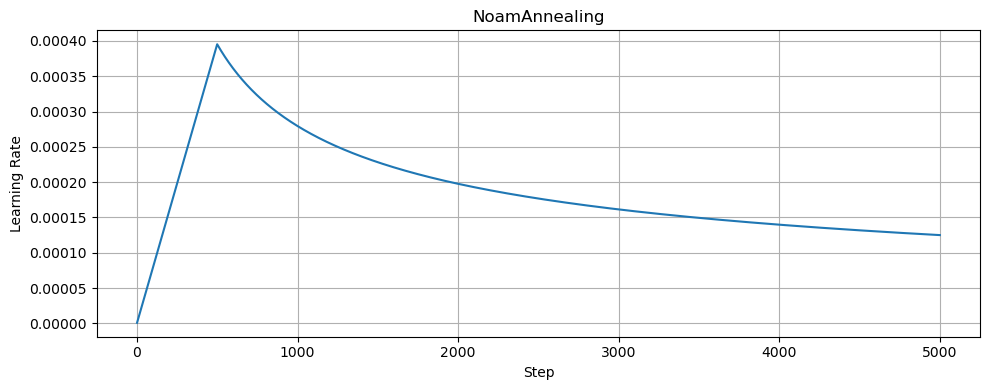

In [37]:
%%capture --no-stdout --no-display

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = E2STransformer(config, audio_paths, train_ds[0][0]).to(device)

scheduler = NoamAnnealing(
    torch.optim.Adam(model.parameters(), lr=0.2),
    d_model=512, warmup_steps=500, min_lr=1e-5
)

learning_rates = []
for _ in range(5000):
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(learning_rates)
ax.grid(True)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('NoamAnnealing')

fig.tight_layout()
plt.show()

## Sanity checks

In [38]:
eeg, audio = train_ds[15296]
eeg, audio = eeg.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

out, tgt = model(eeg, audio)

torch.Size([1, 63, 1145])
torch.Size([63, 1, 1145])


In [39]:
with torch.no_grad():
    restored = tgt[:, 1:-1, :].squeeze()  # (out_seq_len, d_model)
    restored = restored @ model.components  # (out_seq_len, n_freq_bins)
    restored = (restored + model.mean).t().cpu().numpy()  # (n_freq_bins, out_seq_len)

restored = restore(restored)
Audio(restored, rate=train_ds.sr)

# Training

In [11]:
class Trainer:
    def __init__(self, model, device, criterion, optimizer, scheduler, scaler, max_norm, description):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scaler = scaler
        self.max_norm = max_norm
        self.description = description
        self.hist = []  # training history
    
    @staticmethod
    def download_file(path, download_file_name):
        os.chdir('/kaggle/working/')
        zip_name = f"/kaggle/working/{download_file_name}.zip"
        command = f"zip {zip_name} {path} -r"
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            print("Unable to run zip command!")
            print(result.stderr)
            return
        display(FileLink(f'{download_file_name}.zip'))
        
    def fit(self, n_epochs, train_dl, val_dl):
        
        # model checkpoints directory
        model_checkpoint_path = os.path.join(os.getcwd(), 'model_checkpoints')    
        if not os.path.exists(model_checkpoint_path):
            os.mkdir(model_checkpoint_path)
        
        model = self.model.to(self.device).train()
        current_lr = self.scheduler.get_last_lr()[-1]
        total_step = 0
        
        # mean losses
        train_epoch_loss = []
        val_epoch_loss = []
                
        for epoch in trange(n_epochs):
            
            train_epoch_loss = []
            for eeg, audio in (pbar := tqdm(train_dl, total=len(train_dl))):

                total_step += 1
                
                # Move tensors to device
                eeg, audio = eeg.to(self.device), audio.to(self.device)

                # Clear gradients
                self.optimizer.zero_grad()

                # Perform forward pass with mixed precision
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    pred_encoding, encoding = model(eeg, audio)
                    loss = self.criterion(pred_encoding, encoding)
                
                train_epoch_loss.append(loss.item())
                
                # Perform backward pass
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)

                # Perform Gradient Clipping
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_norm).item()

                # Perform Optimization Step
                self.scaler.step(self.optimizer)
                self.scaler.update()

                # Perform Scheduler Step
                self.scheduler.step()
                current_lr = self.scheduler.get_last_lr()[-1]

                # saving history
                self.hist.append((total_step, loss.item(), self.description, 'train'))

                # update tqdm info
                pbar.set_description(
                    f'Step: {total_step}|\t\
                      Lr: {current_lr:.3e}|\t\
                      GradNorm: {grad_norm:.3e}|\t\
                      Train Loss: {loss.item():.3f}|\t'
                )

                # validation
                if total_step % 32 == 0:

                    val_epoch_loss = []
                    model.eval()

                    with torch.no_grad():
                        for eeg, audio in (val_pbar := tqdm(val_dl, total=len(val_dl))):
                            eeg, audio = eeg.to(self.device), audio.to(self.device)
                            pred_encoding, encoding = model(eeg, audio)
                            loss = self.criterion(pred_encoding, encoding).item()
                            val_epoch_loss.append(loss)

                            # update tqdm info
                            val_pbar.set_description(f'Validation|\tVal Loss: {loss:.3f}')
                            
                            if len(val_epoch_loss) == len(val_dl):
                                val_pbar.set_description(f'Validation|\tVal Loss: {np.mean(val_epoch_loss):.3f}')
                        # saving val history
                        self.hist.append((total_step, np.mean(val_epoch_loss), self.description, 'val'))

                    model.train()
                    
                if total_step in [32, 64]:
                    break
                    
                # update tqdm info after epoch
                if len(train_epoch_loss) == len(train_dl):
                    pbar.set_description(
                        f'Step: {total_step}|\t\
                          Lr: {current_lr:.3e}|\t\
                          GradNorm: {grad_norm:.3e}|\t\
                          Train Loss: {np.mean(train_epoch_loss):.3f}|\t\
                          Val Loss: {np.mean(val_epoch_loss):.3f}'
                    )

        # saving model
        self.model = model.eval()
        torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'{self.description}.pth'))

        with open(os.path.join(model_checkpoint_path, 'hist.pickle'), 'wb') as handle:
            pickle.dump(self.hist, handle)
            
        # download files
        self.download_file(os.path.join(model_checkpoint_path, f'{self.description}.pth'), 'model')
        self.download_file(os.path.join(model_checkpoint_path, 'hist.pickle'), 'hist')
        

## Training on a single GPU P100

In [49]:
model = E2STransformer(config, audio_paths, train_ds[0][0])
optimizer = torch.optim.Adam(model.parameters(), lr=config['base_lr'])

trainer = Trainer(
    model=model,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    criterion=nn.MSELoss(),
    optimizer=optimizer,
    scheduler=NoamAnnealing(optimizer=optimizer, d_model=config['d_model'], warmup_steps=len(train_dl) // 5,
                            min_lr=config['min_lr']),
    scaler=torch.cuda.amp.GradScaler(),
    max_norm=10.0,
    description='Transformer_2gpu'
)

In [50]:
%%time
trainer.fit(n_epochs=2, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2796 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


  0%|          | 0/2796 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

/kaggle/working/model.zip

/kaggle/working/hist.zip

CPU times: user 2min 27s, sys: 4.95 s, total: 2min 32s
Wall time: 7min 28s


1.05s/train it

CPU times: user 2min 30s, sys: 6.1 s, total: 2min 36s

Wall time: 7min 20s

## Training on 2 GPU T4 in parallel

![img](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*FpDHkWJhkLL7KxU01Lf9Lw.png)

In [12]:
model = E2STransformer(config, audio_paths, train_ds[0][0])
parallel_model = torch.nn.DataParallel(model)
optimizer = torch.optim.Adam(parallel_model.parameters(), lr=config['base_lr'])

trainer = Trainer(
    model=parallel_model,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    criterion=nn.MSELoss(),
    optimizer=optimizer,
    scheduler=NoamAnnealing(optimizer=optimizer, d_model=config['d_model'], warmup_steps=len(train_dl) // 5,
                            min_lr=config['min_lr']),
    scaler=torch.cuda.amp.GradScaler(),
    max_norm=10.0, 
    description='Transformer_gpu0'
)

In [13]:
%%time
trainer.fit(n_epochs=2, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2796 [00:00<?, ?it/s]

/tmp/ipykernel_28/881025232.py:112: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/EmptyTensor.cpp:31.)
  results = torch.abs(results[:,:,0,:] + results[:,:,1,:]*1j)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/484 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


  0%|          | 0/2796 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

/kaggle/working/model.zip

/kaggle/working/hist.zip

CPU times: user 5min 15s, sys: 13.1 s, total: 5min 28s
Wall time: 9min 10s


CPU times: user 5min 15s, sys: 13.1 s, total: 5min 28s

Wall time: 9min 10s

## Balanced load on a multi-GPU machine

![img](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*F6SXjBp6BCoFTZ26RKnz9A.png)

In [4]:
! wget https://gist.githubusercontent.com/thomwolf/7e2407fbd5945f07821adae3d9fd1312/raw/720118556e8d971fb00de1c59044de63f3775ab1/parallel.py -O /kaggle/working/parallel.py

from torch.nn.parallel import DistributedDataParallel    
from parallel import DataParallelModel, DataParallelCriterion

--2023-08-07 15:45:18--  https://gist.githubusercontent.com/thomwolf/7e2407fbd5945f07821adae3d9fd1312/raw/720118556e8d971fb00de1c59044de63f3775ab1/parallel.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11359 (11K) [text/plain]
Saving to: ‘/kaggle/working/parallel.py’

/kaggle/working/par 100%[===================>]  11.09K  --.-KB/s    in 0s      

2023-08-07 15:45:18 (69.5 MB/s) - ‘/kaggle/working/parallel.py’ saved [11359/11359]



NameError: name 'DistributedDataParallel' is not defined

In [16]:
DistributedDataParallel

torch.nn.parallel.distributed.DistributedDataParallel